Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
metadata = pd.read_csv('/content/drive/MyDrive/Master_DL/DLVision/Practica/data/metadata.csv')
print(metadata.head())
print(len(metadata))
metadata_test = metadata[metadata['split']=='test']
print(len(metadata_test))
metadata_train = metadata[metadata['split']=='train']
print(len(metadata_train))

   image_id  split        sat_image_path              mask_path
0    100034  train  train/100034_sat.jpg  train/100034_mask.png
1    100081  train  train/100081_sat.jpg  train/100081_mask.png
2    100129  train  train/100129_sat.jpg  train/100129_mask.png
3    100703  train  train/100703_sat.jpg  train/100703_mask.png
4    100712  train  train/100712_sat.jpg  train/100712_mask.png
8570
1101
6226


In [ ]:
import matplotlib.pyplot as plt
import cv2

In [ ]:
# train_img=[]
# mask_train=[]
# for i in (range(6226)):
#     path='/content/drive/MyDrive/Master_DL/DLVision/Practica/data/'
#     image = plt.imread(path+metadata_train['sat_image_path'][i])
#     mask = plt.imread(path+metadata_train['mask_path'][i])
#     image = cv2.resize(image,(128,128),interpolation=cv2.INTER_CUBIC)
#     mask = cv2.resize(mask,(128,128),interpolation=cv2.INTER_CUBIC)
#     grayed_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#     train_img.append(image)
#     mask_train.append(grayed_mask)

Cargar los datos

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Ruta base de tus datos e imágenes procesadas
path = '/content/drive/MyDrive/Master_DL/DLVision/Practica/data/'
processed_path = '/content/drive/MyDrive/Master_DL/DLVision/Practica/processed/'

os.makedirs(processed_path, exist_ok=True)

# Rutas a archivos procesados
train_img_file = os.path.join(processed_path, 'train_img.npy')
mask_train_file = os.path.join(processed_path, 'mask_train.npy')

# Si ya existen, los cargamos directamente
if os.path.exists(train_img_file) and os.path.exists(mask_train_file):
    print("Cargando imágenes procesadas desde disco...")
    train_img = np.load(train_img_file)
    mask_train = np.load(mask_train_file)
else:
    print("Procesando imágenes por primera vez...")

    def load_and_process(i):
        image = plt.imread(os.path.join(path, metadata_train['sat_image_path'][i]))
        mask = plt.imread(os.path.join(path, metadata_train['mask_path'][i]))
        image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_CUBIC)
        mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_CUBIC)
        grayed_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        return image, grayed_mask

    with ThreadPoolExecutor(max_workers=8) as executor:
        results = list(tqdm(executor.map(load_and_process, range(len(metadata_train))), total=len(metadata_train)))

    # Separar resultados
    train_img, mask_train = zip(*results)

    # Convertir a arrays NumPy
    train_img = np.array(train_img)
    mask_train = np.array(mask_train)

    # Guardar arrays para uso futuro
    np.save(train_img_file, train_img)
    np.save(mask_train_file, mask_train)
    print("Imágenes procesadas y guardadas.")


Cargando imágenes procesadas desde disco...


Data Augmentation

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset
import torch

import torch
import numpy as np
from torch.utils.data import Dataset
import albumentations as A

from torch.utils.data import Dataset
import torch
import numpy as np

class MyDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        msk = self.masks[idx]

        # Si la imagen es un tensor de PyTorch, se convierte a numpy array
        if isinstance(img, torch.Tensor):
            img = img.numpy().transpose((1, 2, 0))  # PyTorch forma (C, H, W) -> Numpy forma (H, W, C)

        # Si la máscara es un tensor de PyTorch, se convierte a numpy array
        if isinstance(msk, torch.Tensor):
            msk = msk.numpy().squeeze()

        # Aplicar las transformaciones si existen
        if self.transform:
            augmented = self.transform(image=img, mask=msk)
            img = augmented['image']
            msk = augmented['mask']

        # Convertir las imágenes de vuelta a tensor y asegurarse de que tengan la forma adecuada

        #img = torch.as_tensor(img).permute(2, 0, 1).float()  # De numpy array (H, W, C) a tensor (C, H, W)
        img = torch.as_tensor(img).float()  # De numpy array (H, W, C) a tensor (C, H, W)
        msk = torch.as_tensor(msk).unsqueeze(0).float()  # Si es una máscara binaria, agregar la dimensión de canal

        return img, msk





In [ ]:
import albumentations as A
def get_augmentations(image_size=128, crop_prob=1):
    return A.Compose([
        A.RandomCrop(width=image_size, height=image_size, p=crop_prob),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.25),
        ToTensorV2()  # Convierte la imagen a un tensor
    ], p=1)


In [ ]:
AUG_img = get_augmentations()(image = train_img[0],mask = mask_train[0])

Visualizamos un ejemplo de img

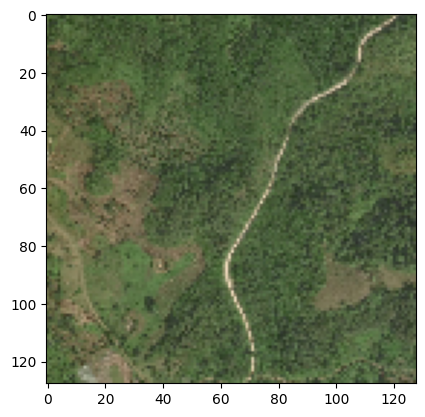

In [ ]:
plt.imshow(train_img[0])

Imagen de ejemplo con las transformaciones aplicadas

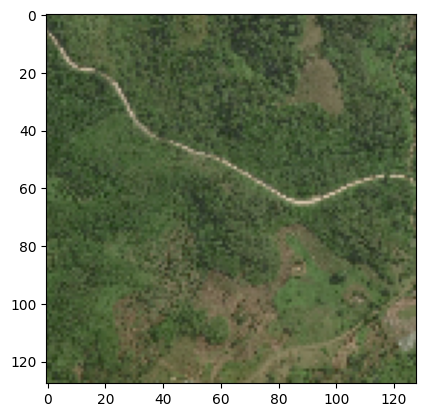

In [ ]:
plt.imshow(AUG_img['image'].to('cpu').numpy().transpose(1,2,0))

In [ ]:
train_imgs,train_masks = train_img.copy(),mask_train.copy()

In [ ]:
len(train_imgs)

6226

Visualizamos algunas img junto con sus máscaras

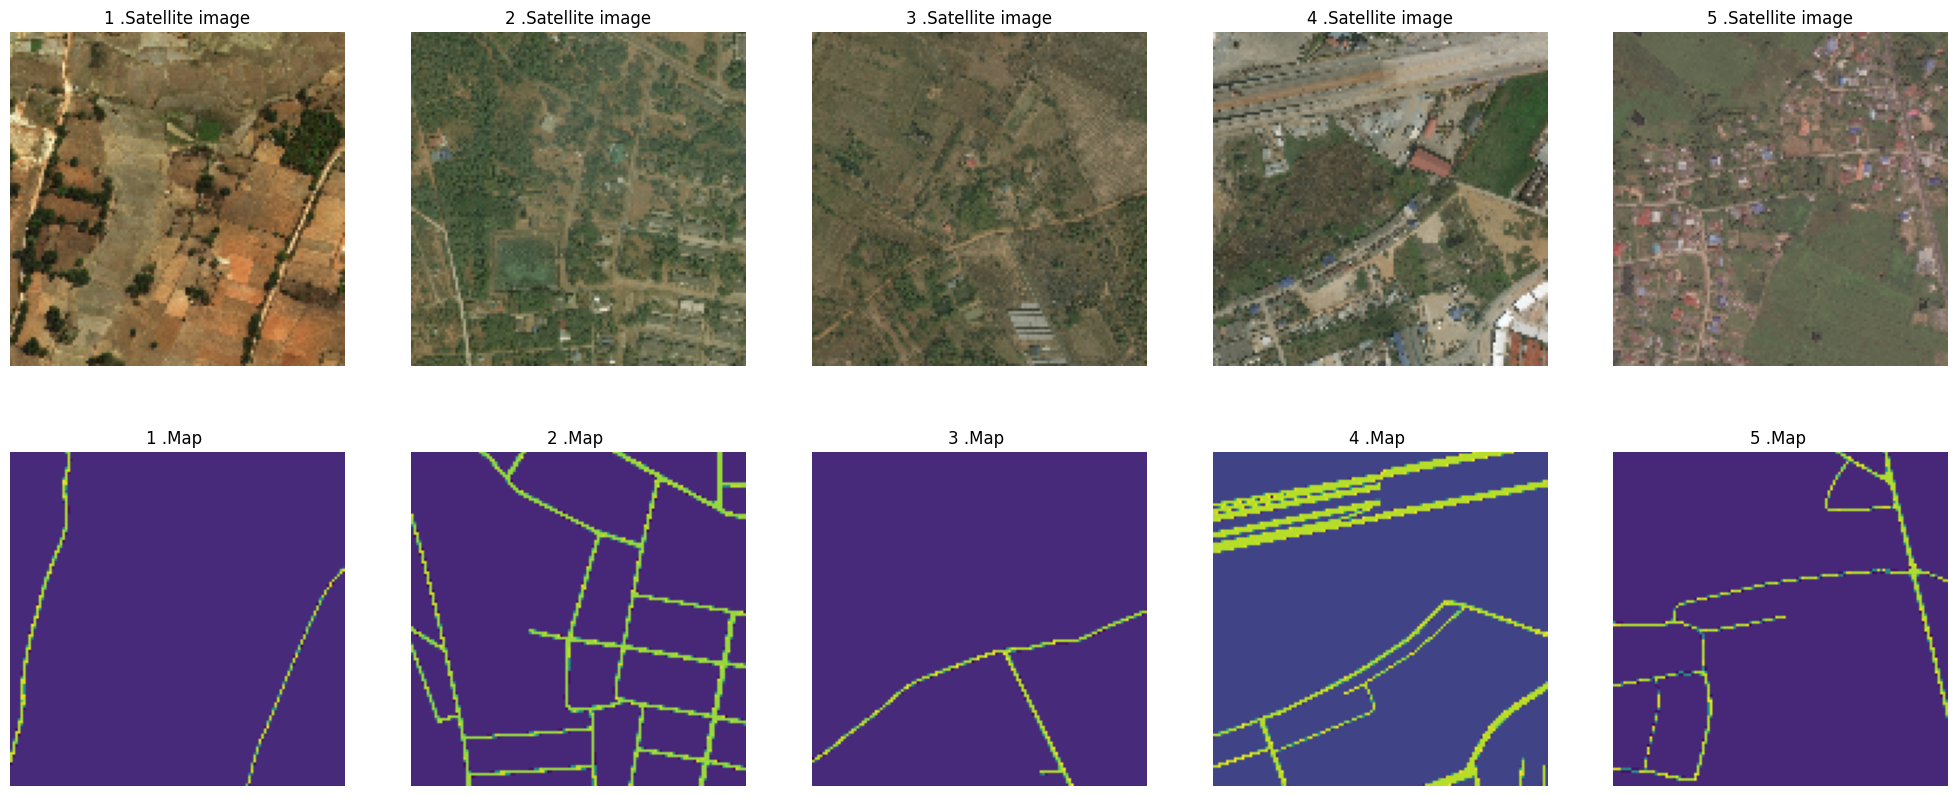

In [ ]:
plt.figure(figsize=(25,10))
for i in range(1,6):
    image, mask = train_imgs[i+10], train_masks[i+10]
    plt.subplot(2,5,i)
    plt.imshow(image)
    plt.title(str(i) + " .Satellite image")
    plt.axis("off")

    plt.subplot(2,5,i + 5)
    plt.imshow(mask)
    plt.title(str(i) + " .Map ")
    plt.axis("off")
plt.show()

Se transforman las imagenes a arrays de numpy

In [ ]:
import numpy as np
train_imgs=np.array(train_imgs)
train_masks=np.array(train_masks)

In [ ]:
print(train_imgs.shape)
print(train_masks.shape)

(6226, 128, 128, 3)
(6226, 128, 128)


Se dvividen los datos en train y test

In [ ]:
train_img1=train_imgs[0:3113,:,:,:]
train_mask1=train_masks[0:3113,:,:]
train_img2=train_imgs[3113:4565,:,:,:]
train_mask2=train_masks[3113:4565,:,:]
test_data=train_imgs[4565:6226,:,:,:]
test_masks=train_masks[4565:6226,:,:]

In [ ]:
print(train_img1.shape)
print(train_mask1.shape)
print(train_img2.shape)
print(train_mask2.shape)
print(test_data.shape)
print(test_masks.shape)

(3113, 128, 128, 3)
(3113, 128, 128)
(1452, 128, 128, 3)
(1452, 128, 128)
(1661, 128, 128, 3)
(1661, 128, 128)


Se escalan

In [ ]:
train_img1 = train_img1 / 255.0
train_img2 = train_img2 / 255.0
test_data = test_data/255.0

In [ ]:
# # Si fuese necesario que las mascaras tengan un canal, descomentar
# train_mask1 = np.expand_dims(train_mask1, axis=-1)
# train_mask2 = np.expand_dims(train_mask2, axis=-1)
# test_masks=  np.expand_dims(test_masks, axis=-1)

In [ ]:
print(train_img1.shape)
print(train_mask1.shape)
print(train_img2.shape)
print(train_mask2.shape)
print(test_data.shape)
print(test_masks.shape)

(3113, 128, 128, 3)
(3113, 128, 128)
(1452, 128, 128, 3)
(1452, 128, 128)
(1661, 128, 128, 3)
(1661, 128, 128)


Model 1 - Simple U-net


In [ ]:
pip install pytorch-lightning


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import gc
from sklearn.metrics import jaccard_score
import torch

# Definición de la Red U-Net en PyTorch
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Capa de contracción (Encoder)
        self.encoder1 = self.contract_block(in_channels, 64)
        self.encoder2 = self.contract_block(64, 128)
        self.encoder3 = self.contract_block(128, 256)
        self.encoder4 = self.contract_block(256, 512)

        # Capa de cuello de botella (Bottleneck)
        self.bottleneck = self.contract_block(512, 1024)

        # Capa de expansión (Decoder)
        self.upconv6 = self.expand_block(1024, 512)
        self.upconv7 = self.expand_block(512*2, 256)
        self.upconv8 = self.expand_block(256*2, 128)
        self.upconv9 = self.expand_block(128*2, 64)

        # Capa final
        self.final_conv = nn.Conv2d(64*2, out_channels, kernel_size=1)

    def contract_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

    def expand_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        # Capa de Up
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)

        # Capa de cuello de botella
        bottleneck = self.bottleneck(enc4)

        # Capa de Down
        up6 = self.upconv6(bottleneck)
        up6 = torch.cat([up6, enc4], dim=1)  # Concatenar con la capa correspondiente del encoder

        up7 = self.upconv7(up6)
        up7 = torch.cat([up7, enc3], dim=1)

        up8 = self.upconv8(up7)
        up8 = torch.cat([up8, enc2], dim=1)

        up9 = self.upconv9(up8)
        up9 = torch.cat([up9, enc1], dim=1)

        # Capa final
        out = self.final_conv(up9)
        return out


# Crear el modelo de PyTorch Lightning
class UNetLightning(pl.LightningModule):
    def __init__(self, in_channels=3, out_channels=1, transform=None):
        super(UNetLightning, self).__init__()
        self.model = UNet(in_channels, out_channels)
        self.criterion = nn.BCEWithLogitsLoss()

        self.transform = transform
        self.val_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, msks = batch
        msks = msks.squeeze(1)

        outputs = self.model(imgs)
        outputs = F.interpolate(outputs, size=(128, 128), mode='bilinear', align_corners=True)

        loss = self.criterion(outputs.squeeze(1), msks)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        return optimizer

    def validation_step(self, batch, batch_idx):
        imgs, msks = batch
        msks = msks.squeeze(1)

        outputs = self.model(imgs)
        outputs = F.interpolate(outputs, size=(128, 128), mode='bilinear', align_corners=True)

        loss = self.criterion(outputs.squeeze(1), msks)

        return {'val_loss': loss}

    def on_validation_epoch_end(self):

        if self.val_outputs:

            val_loss = torch.stack([x['val_loss'] for x in self.val_outputs]).mean()
            self.log('val_loss', val_loss, prog_bar=True)
        else:

            self.log('val_loss', torch.tensor(0.0), prog_bar=True)
            print("Warning: No validation outputs were collected!")

        #self.val_outputs.clear()


    def val_dataloader(self):
        dataset = MyDataset(images=test_data, masks=test_masks, transform=transform)
        return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

    def on_validation_batch_end(self, outputs, batch, batch_idx):
        self.val_outputs.append(outputs)


Entrenamiento del modelo

In [ ]:
# Datos de entrenamiento y validación
from torch.utils.data import DataLoader

transform = get_augmentations(image_size=128)

# Supón que train_img1, train_mask1, etc., son listas de imágenes y máscaras para cada parte
BATCH_SIZE = 32
EPOCHS_PER_PART = 15

trainer = pl.Trainer(
    max_epochs=EPOCHS_PER_PART,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    precision=16 if torch.cuda.is_available() else 32,
)

for part_num, (images, masks) in enumerate([
    (train_img1, train_mask1),
    (train_img2, train_mask2)
]):
    print(f"Entrenando con parte {part_num + 1} del dataset")

    # Dataset y DataLoader para esta parte
    dataset = MyDataset(images, masks, transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

    # Crear modelo de PyTorch Lightning
    model = UNetLightning(in_channels=3, out_channels=1)

    # Entrenamiento con PyTorch Lightning
    trainer.fit(model, dataloader)

    # Liberar memoria antes de cargar la siguiente parte
    del dataset, dataloader
    gc.collect()
    torch.cuda.empty_cache()

/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Entrenando con parte 1 del dataset


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | UNet              | 29.8 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
29.8 M    Trainable params
0         Non-trainable params
29.8 M    Total params
119.175   Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Entrenando con parte 2 del dataset


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/lightning_logs/version_59/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | UNet              | 29.8 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
29.8 M    Trainable params
0         Non-trainable params
29.8 M    Total params
119.175   Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Evaluación del modelo

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import jaccard_score

def evaluate(model, val_loader, criterion, device='cuda'):
    model.eval()  # Poner el modelo en modo evaluación
    all_losses = []
    all_ious = []

    with torch.no_grad():
        for imgs, msks in val_loader:
            imgs = imgs.to(device)
            msks = msks.to(device)

            imgs = imgs.permute(0, 3, 2, 1)  # Cambiar de (B, C, H, W) a (B, H, W, C)
            #msks = msks.permute(0, 2, 3, 1)  # Cambiar de (B, C, H, W) a (B, H, W, C)

            # Forward pass
            outputs = model(imgs)

            # Para que las salidas tengan el mismo tamaño que las máscaras
            outputs = F.interpolate(outputs, size=(128, 128), mode='bilinear', align_corners=True)

            # Calcula la pérdida
            loss = criterion(outputs.squeeze(1), msks.squeeze(1))
            all_losses.append(loss.item())

            # Convertir las salidas continuas a binarias
            preds = torch.sigmoid(outputs) > 0.5  # Umbral de 0.5 para obtener las predicciones binarias

            preds = preds.int()
            msks = msks.int()

            # Calcular IoU
            iou = calculate_iou(preds.squeeze(1), msks.squeeze(1))
            all_ious.append(iou)

    # Promedio de pérdidas e IoU
    avg_loss = sum(all_losses) / len(all_losses)
    avg_iou = sum(all_ious) / len(all_ious)

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Validation IoU: {avg_iou:.4f}")

def calculate_iou(preds, targets, eps=1e-6):
    """
    Calcula el coeficiente de Intersection over Union (IoU) para segmentación binaria.
    """
    preds = preds.view(-1).cpu().numpy()
    targets = targets.view(-1).cpu().numpy()
    #print(preds, targets)

    return jaccard_score(targets, preds, average='binary', zero_division=1)


In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
val_dataset = MyDataset(test_data, test_masks, transform=None)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Llamada a la evaluación
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

evaluate(model, val_loader, criterion, device='cuda')

Validation Loss: 0.6948
Validation IoU: 0.0294


Visualizamos los resultados

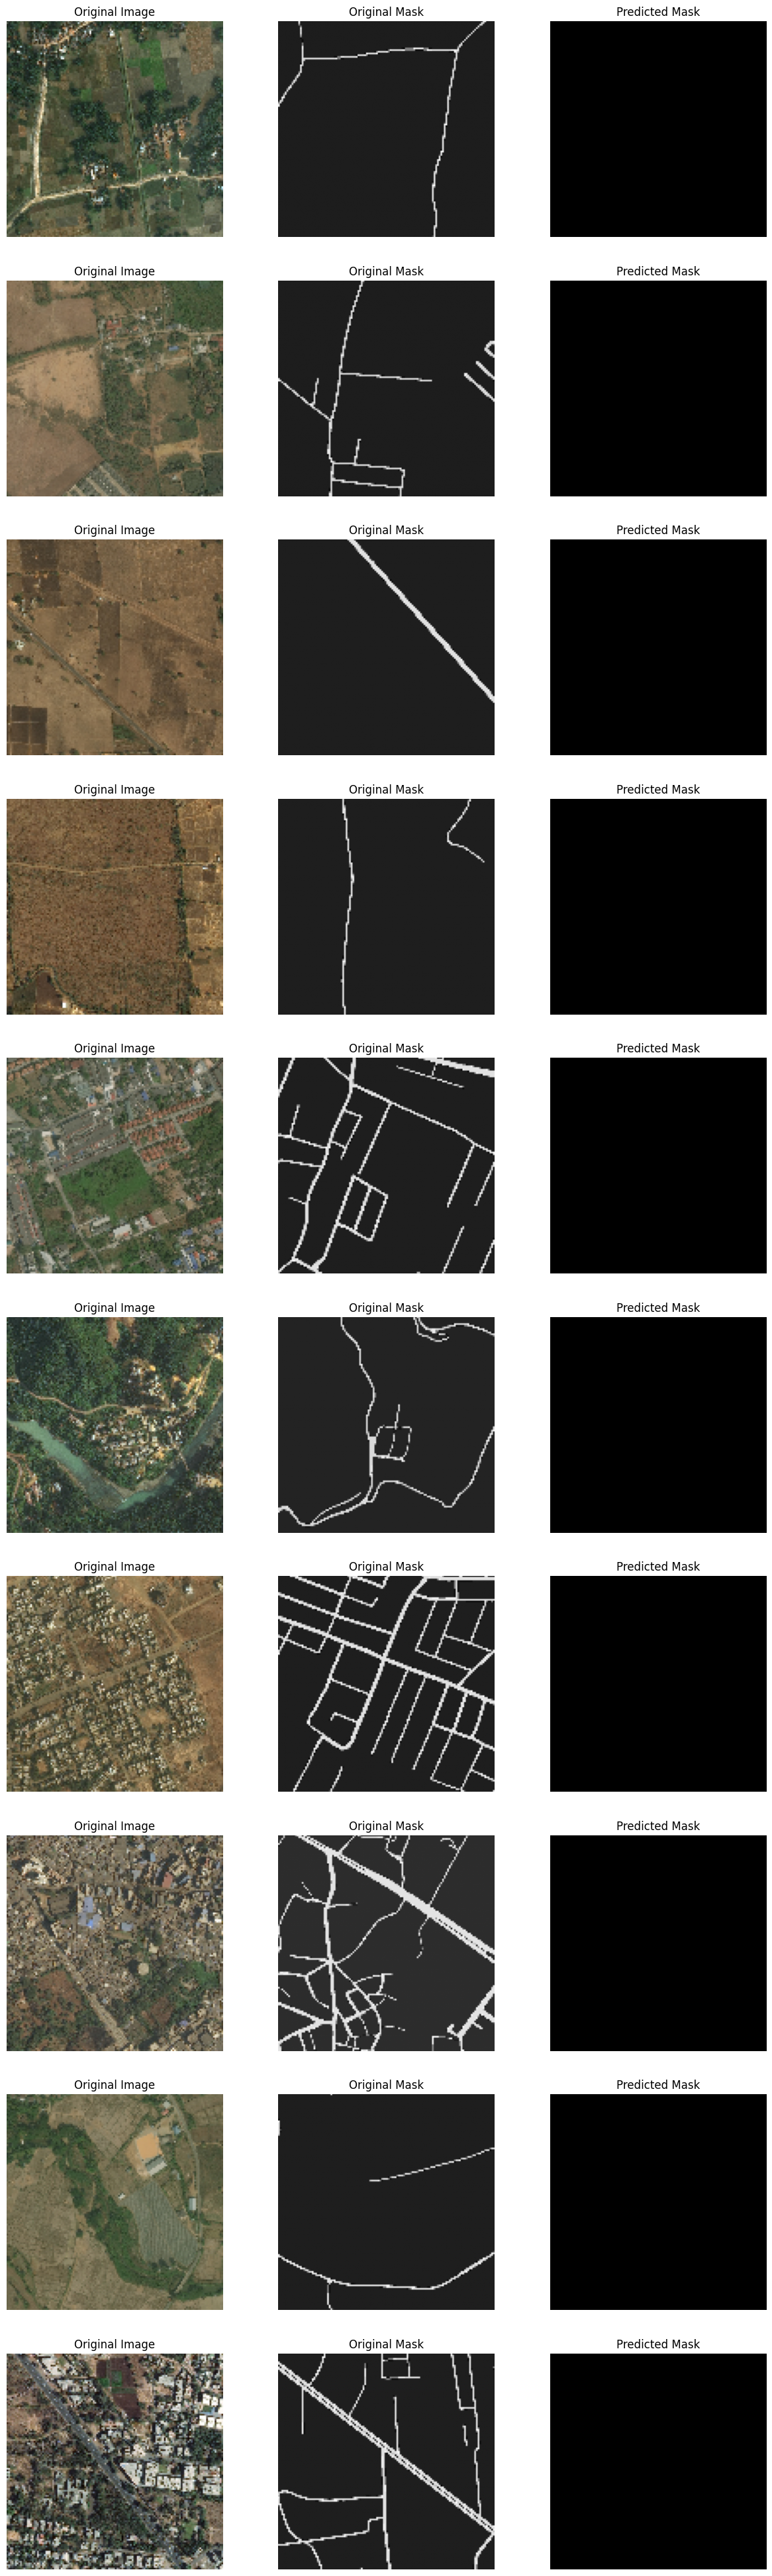

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch


def visualize_predictions(model, images, masks, device, num_samples=10):
    # Seleccionamos un número aleatorio de imágenes
    indices = random.sample(range(len(images)), num_samples)
    model.eval()

    # Preparamos el gráfico
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            # Convertir las imágenes y máscaras de numpy a tensores
            single_image = torch.tensor(images[idx]).unsqueeze(0).float().to(device)  # Cargar la imagen al dispositivo
            single_mask = torch.tensor(masks[idx]).unsqueeze(0).float().to(device)    # Cargar la máscara al dispositivo
            single_image = single_image.permute(0, 3, 2, 1)  # Cambiar de (B, C, H, W) a (B, H, W, C)
            # Predicción de la máscara
            predicted_mask = model(single_image)
            predicted_mask = predicted_mask.squeeze(0).squeeze(0).cpu().numpy()  # Eliminar las dimensiones innecesarias
            predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Convertir a binario usando un umbral de 0.5

            # Convertir la imagen y la máscara a formato numpy para la visualización
            original_image = single_image.squeeze(0).cpu().numpy().transpose((1, 2, 0))  # Convertir a (H, W, C)
            original_mask = single_mask.squeeze(0).squeeze(0).cpu().numpy()  # Máscara original (1 canal)

            # Mostrar la imagen original
            axs[i, 0].imshow(original_image)
            axs[i, 0].set_title('Original Image')
            axs[i, 0].axis('off')

            # Mostrar la máscara original
            axs[i, 1].imshow(original_mask, cmap='gray')
            axs[i, 1].set_title('Original Mask')
            axs[i, 1].axis('off')

            # Mostrar la máscara predicha
            axs[i, 2].imshow(predicted_mask, cmap='gray')
            axs[i, 2].set_title('Predicted Mask')
            axs[i, 2].axis('off')

    # Mostrar el gráfico
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

visualize_predictions(model, train_img1, train_mask1, device)


In [ ]:
#limpiar memoria ram
import gc
gc.collect()
torch.cuda.empty_cache()